In [1]:
library("ggplot2")
library("dplyr")
library("corrplot")
library("plyr")
library("randomForest")
library(yardstick)
library(ggplot2)
# library("RSNNS")



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


corrplot 0.92 loaded

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


For binary class

In [2]:
library(caret)
library(InformationValue)
library(ISLR)

Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘InformationValue’


The following objects are masked from ‘package:caret’:

    confusionMatrix, precision, sensitivity, specificity


The following objects are masked from ‘package:yardstick’:

    npv, precision, sensitivity, specificity




In [3]:
df <- read.csv("../input/bank-marketing-analysis/bank-additional-full.csv", sep = ";")[26001:40000,]
# check the basic info of it
# we can see that there is 41188 rows and 21 columns
dim(df)

[1] 14000    21

In [4]:
str(df)

'data.frame':	14000 obs. of  21 variables:
 $ age           : int  53 31 51 34 35 35 42 31 43 37 ...
 $ job           : chr  "blue-collar" "services" "unemployed" "services" ...
 $ marital       : chr  "divorced" "single" "divorced" "married" ...
 $ education     : chr  "basic.9y" "high.school" "university.degree" "high.school" ...
 $ default       : chr  "no" "no" "unknown" "no" ...
 $ housing       : chr  "no" "yes" "yes" "no" ...
 $ loan          : chr  "no" "no" "no" "no" ...
 $ contact       : chr  "cellular" "telephone" "cellular" "cellular" ...
 $ month         : chr  "nov" "nov" "nov" "nov" ...
 $ day_of_week   : chr  "wed" "wed" "wed" "wed" ...
 $ duration      : int  625 88 120 89 616 56 238 112 748 184 ...
 $ campaign      : int  1 1 2 3 2 4 4 2 2 4 ...
 $ pdays         : int  999 999 999 999 999 999 999 999 999 999 ...
 $ previous      : int  0 1 1 1 0 0 0 0 0 0 ...
 $ poutcome      : chr  "nonexistent" "failure" "failure" "failure" ...
 $ emp.var.rate  : num  -0.1 -0.1 -0.

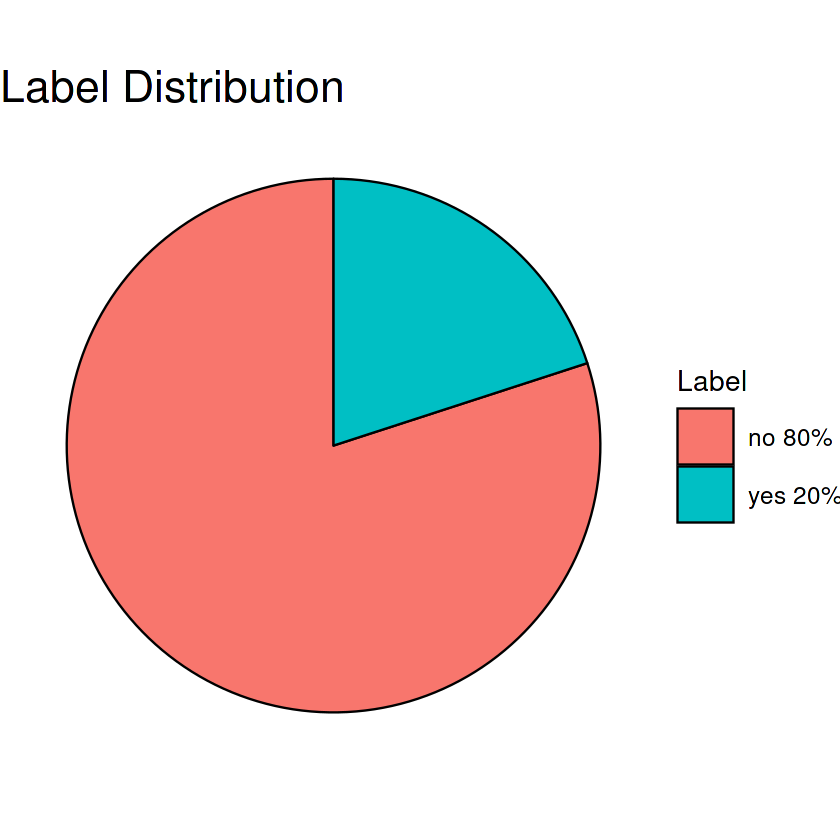

In [5]:
plotdata <- count(df$y) %>%
  mutate(prop = round(freq/sum(freq), 1))

label <- paste0(plotdata$x, " ", plotdata$prop * 100, "%")


ggplot(plotdata,
       aes(x="",y=prop,fill=x)) +
  geom_bar(width = 1, 
           stat = "identity",
           color = "black") +
  coord_polar("y", start = 0, direction = 1) +
  theme_void() +
  theme(legend.key.size = unit(35, "pt"),
        plot.title  = element_text(size = rel(2.4)),
        legend.text = element_text(size = rel(1.3)),
        legend.title = element_text(size = rel(1.5))
        ) +
  labs(title = "Label Distribution") +
  scale_fill_discrete(labels = label, name="Label")

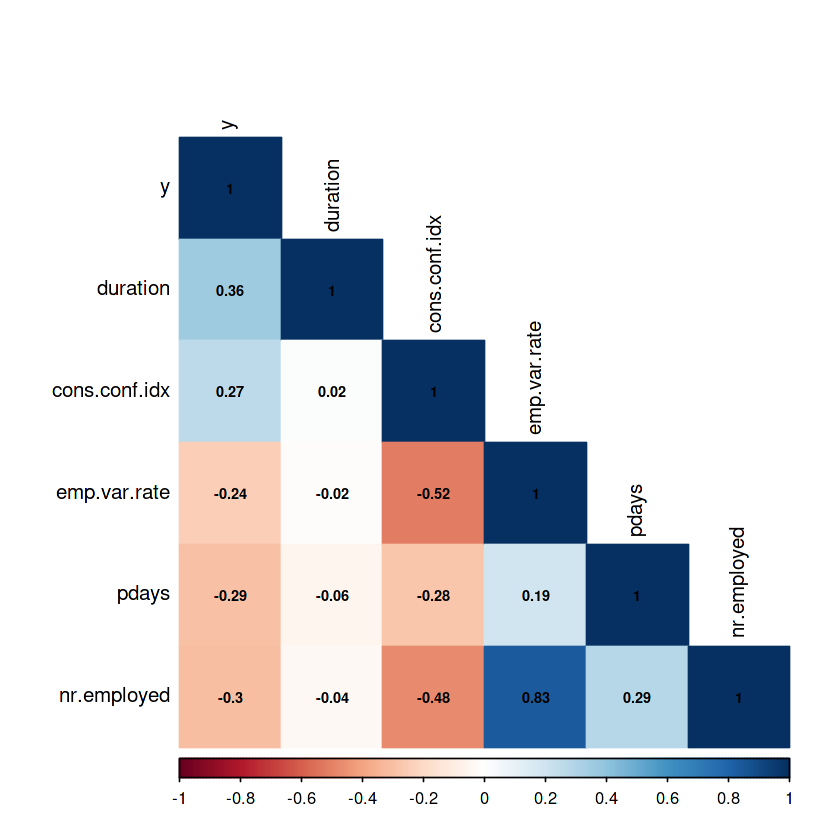

In [6]:
# for all the numerical variable, change variable become 0 and 1
y_h <- c("no" = 0, "yes"= 1)
df$y = as.integer(revalue(df$y,y_h))
numeric_vars <- which(sapply(df, is.numeric))
all_num_var <- df[, numeric_vars]

# Then do the pearson correlation for all numerical data
corr_var <- cor(all_num_var, use = "pairwise.complete.obs")

# sort
corr_sort <- (as.matrix(sort(corr_var[,"y"], decreasing = TRUE)))
CorHigh <- names(which(apply(corr_sort, 1, function(x) abs(x)>0.2)))
cor_numVar <- corr_var[CorHigh, CorHigh]

# Plot the pearson correlation graph
corrplot(cor_numVar,tl.col = "black", 
         number.cex = .7,
         addCoef.col = "black",
         method = 'color',
         type='lower')

In [7]:
final_numeric_var <- CorHigh

# check factor data
factorvars <- which(!sapply(df, is.numeric))
#
factorvars

job     marital   education     default     housing        loan 
          2           3           4           5           6           7 
    contact       month day_of_week    poutcome 
          8           9          10          15

# Categorical Variable

## Unrank
* marital
* **default**
* **housing**
* **loan**
* **contact**
* month
* day of week
* **poutcome**

## Rank
* education

In [8]:
df$contact = as.factor(revalue(df$contact,c("cellular"=1, "telephone"=0)))

# map unknown to 0, means no
df$loan = as.factor(revalue(df$loan,c("yes"=1,"unknown"=0,"no"=0)))

df$housing = as.factor(revalue(df$housing,c("yes"=1,"unknown"=0,"no"=0)))

df$default = as.factor(revalue(df$default,c("yes"=0,"unknown"=0,"no"=1)))

# change days to factor in the form of ranked data
df$pdays = as.factor(df$pdays)

df$poutcome = as.factor(revalue(df$poutcome, c("nonexistent"=0, "failure"=0, "success"=1)))

The following `from` values were not present in `x`: yes



In [9]:
# do the pca for numerical
numeric_vars <- which(sapply(df[,1:20], is.numeric))
numeric_vars

all_num_var <- df[, numeric_vars]
PCA1 <- prcomp(all_num_var, center = TRUE, scale. = TRUE)

# summary the importance of components
summary(PCA1)

# I will choose the first 7 since it's over all 95% variation of our dataset
final_num_value <- PCA1$x[,1:6]
final_num_value <- cbind(final_num_value, df[,"y"])
colnames(final_num_value) <- c("PC1" ,"PC2" ,"PC3", "PC4" ,"PC5","PC6","y")
colnames(final_num_value)
dim(final_num_value)

# then combine all factor values into one single dataframe
# and use it as our final input dataset
factor_var <- which(!sapply(df, is.numeric))
final_dataset <- cbind(final_num_value, df[,factor_var])
head(final_dataset)

age       duration       campaign       previous   emp.var.rate 
             1             11             12             14             16 
cons.price.idx  cons.conf.idx      euribor3m    nr.employed 
            17             18             19             20

Importance of components:
                          PC1    PC2    PC3    PC4    PC5     PC6    PC7
Standard deviation     1.8087 1.0792 1.0615 1.0157 0.9603 0.91130 0.7655
Proportion of Variance 0.3635 0.1294 0.1252 0.1146 0.1025 0.09227 0.0651
Cumulative Proportion  0.3635 0.4929 0.6181 0.7328 0.8352 0.92749 0.9926
                           PC8     PC9
Standard deviation     0.23278 0.11149
Proportion of Variance 0.00602 0.00138
Cumulative Proportion  0.99862 1.00000

[1] "PC1" "PC2" "PC3" "PC4" "PC5" "PC6" "y"

[1] 14000     7

,PC1,PC2,PC3,PC4,PC5,PC6,y,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,poutcome
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<fct>,<fct>
26001,3.562081,0.4216859,-2.6529088,-0.6649328,-0.4445843,-0.2437490,0,blue-collar,divorced,basic.9y,1,0,0,1,nov,wed,999,0
26002,3.513188,-0.1657676,-1.1033277,0.6233573,1.7094571,-1.4429787,0,services,single,high.school,1,1,0,0,nov,wed,999,0
26003,3.426007,0.2150253,-1.9435303,1.4805452,0.6524553,-0.8178724,0,unemployed,divorced,university.degree,0,1,0,1,nov,wed,999,0
26004,3.591205,0.1251528,-0.7366481,1.2543723,0.8001787,-1.6697581,0,services,married,high.school,1,0,0,1,nov,wed,999,0
26005,3.732192,0.2929478,-1.4217811,-0.9782444,-0.3199002,-1.1600553,0,admin.,married,professional.course,1,0,0,1,nov,wed,999,0
26006,3.875402,1.1588734,-0.1601835,0.9218728,0.1724579,-0.9319548,0,entrepreneur,divorced,university.degree,1,0,0,1,nov,wed,999,0


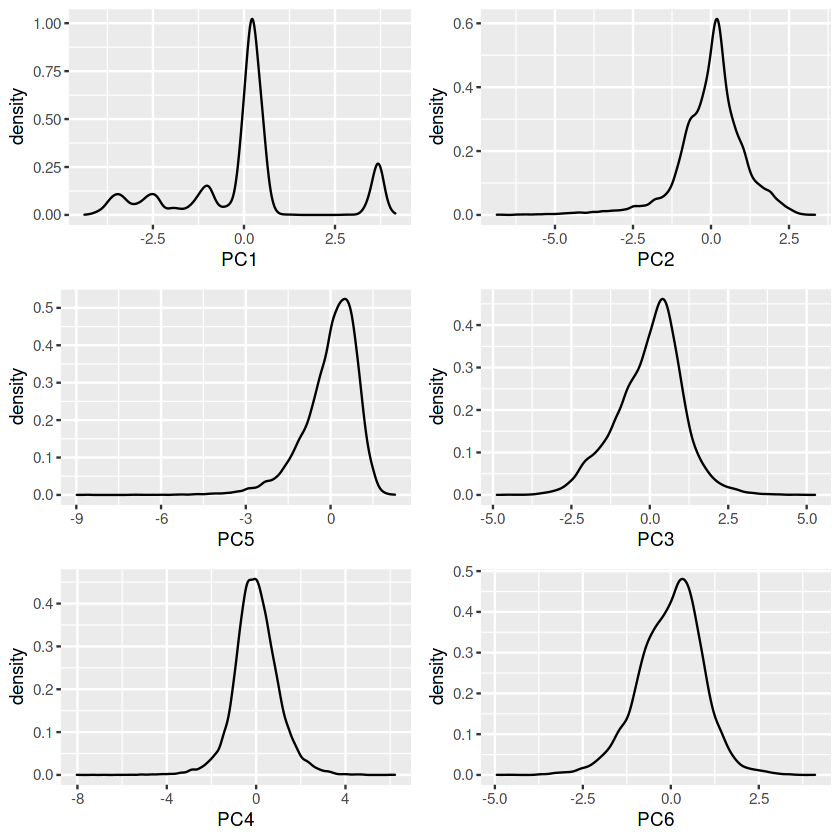

In [10]:
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

s1 <- ggplot(final_dataset, aes(PC1)) +
    geom_density()
s2 <- ggplot(final_dataset, aes(PC2)) +
    geom_density()
s3 <- ggplot(final_dataset, aes(PC3)) +
    geom_density()
s4 <- ggplot(final_dataset, aes(PC4)) +
    geom_density()
s5 <- ggplot(final_dataset, aes(PC5)) +
    geom_density()
s6 <- ggplot(final_dataset, aes(PC6)) +
    geom_density()

layout <- matrix(c(1,2,5,3,4,6),3,2,byrow=TRUE)

multiplot(s1, s2, s3, s4, s5, s6, layout=layout)

In [11]:
train <- sample(nrow(final_dataset), 0.8*nrow(final_dataset))
train_set <- final_dataset[train,]
valid <- final_dataset[-train,]
dim(train_set)
dim(valid)

[1] 11200    18

[1] 2800   18

## Random Forest

In [12]:
set.seed(1234)
# train_set$y = as.factor(train_set$y)
rf_model = randomForest(as.factor(y)~.,data=train_set,importance=TRUE,proximity=TRUE)
rf_model


Call:
 randomForest(formula = as.factor(y) ~ ., data = train_set, importance = TRUE,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 16%
Confusion matrix:
     0    1 class.error
0 8320  641   0.0715322
1 1151 1088   0.5140688

### Mean Accuracy Decrease
#### By changing the value of a variable to a random number, the accuracy of random forest prediction is reduced. The greater the value, the greater the importance of the variable

In [13]:
## Look at variable importance:
# round(importance(rf_train), 3)
imp_acc <- importance(rf_model, type=1)
accImportance <- data.frame(Feature=row.names(imp_acc), Importance=imp_acc[,1])

These are important features including those generated by PCA, and intrinsic ones.

In [14]:
accImportance[order(accImportance$Importance,decreasing = TRUE),]

,Feature,Importance
,<chr>,<dbl>
PC4,PC4,80.750271
PC1,PC1,80.673489
PC5,PC5,73.492663
PC2,PC2,57.545351
PC6,PC6,44.185627
month,month,42.792147
PC3,PC3,42.517572
pdays,pdays,30.923294
day_of_week,day_of_week,21.172479


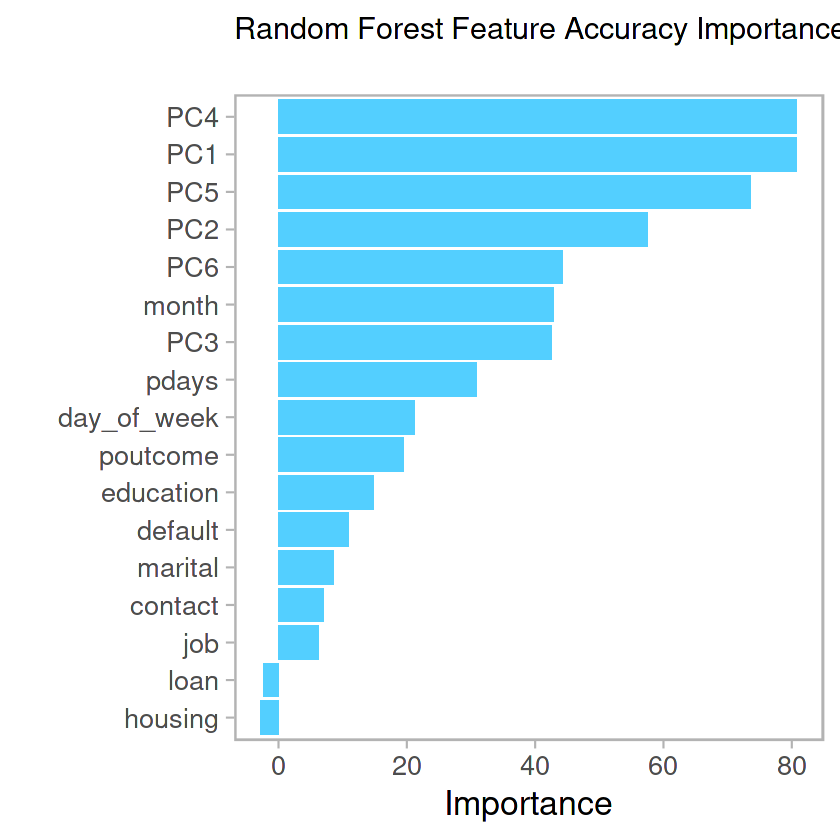

In [15]:
p <- ggplot(accImportance, aes(x=reorder(Feature, Importance), y=Importance)) +
     geom_bar(stat="identity", fill="#53cfff") +
     coord_flip() + 
     theme_light(base_size=20) +
     xlab("") +
     ylab("Importance") + 
     ggtitle("Random Forest Feature Accuracy Importance\n") +
     theme(plot.title=element_text(size=18),
          panel.grid=element_blank())
p

### Mean Gini Decrease
#### Calculate the influence of each variable on the observations at each node of the classification tree, that is, the ability to classify, so as to compare the importance of variables. The larger the value, the more important the variable is.

In [16]:
imp_gini <- importance(rf_model, type=2)
giniImportance <- data.frame(Feature=row.names(imp_gini), Importance=imp_gini[,1])
giniImportance[order(giniImportance$Importance,decreasing = TRUE),]

,Feature,Importance
,<chr>,<dbl>
PC1,PC1,573.96459
PC4,PC4,550.03869
PC5,PC5,414.02291
PC2,PC2,401.76515
PC3,PC3,345.37311
PC6,PC6,321.88063
pdays,pdays,172.25722
month,month,147.09110
job,job,128.60728


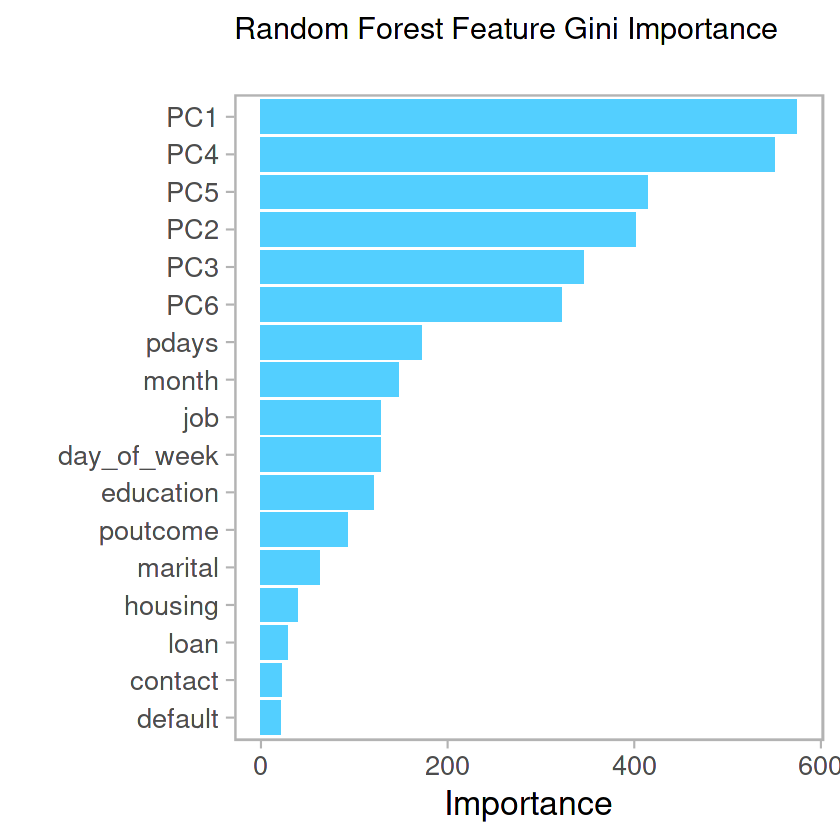

In [17]:
p <- ggplot(giniImportance, aes(x=reorder(Feature, Importance), y=Importance)) +
     geom_bar(stat="identity", fill="#53cfff") +
     coord_flip() + 
     theme_light(base_size=20) +
     xlab("") +
     ylab("Importance") + 
     ggtitle("Random Forest Feature Gini Importance\n") +
     theme(plot.title=element_text(size=18),
          panel.grid=element_blank())
p

In [18]:
unique(final_dataset$month)

[1] "nov" "dec" "mar" "apr" "may" "jun" "jul" "aug" "sep" "oct"

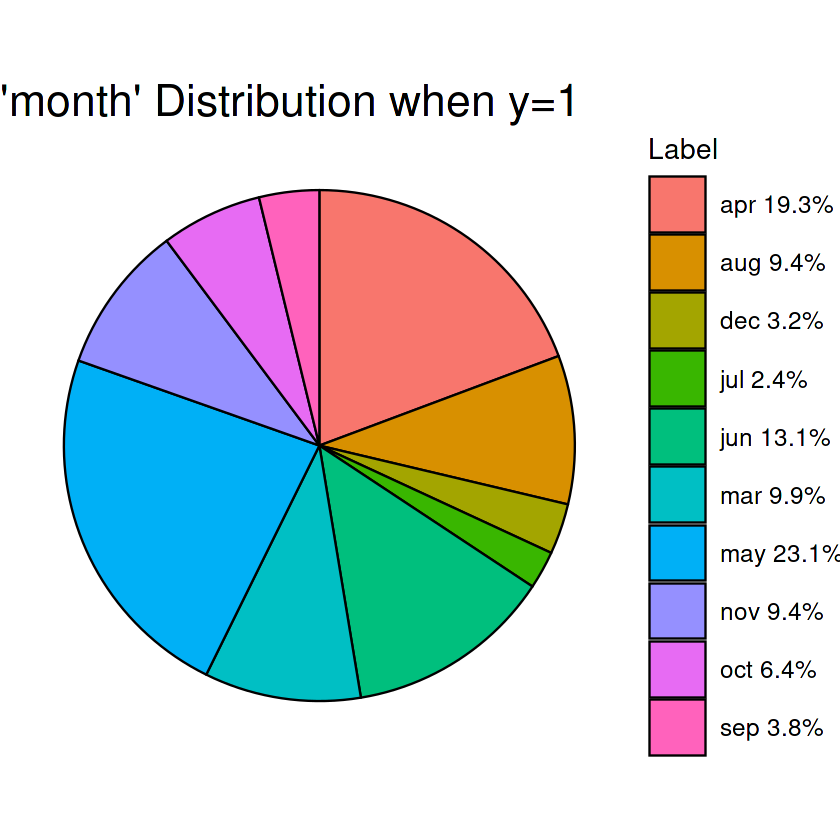

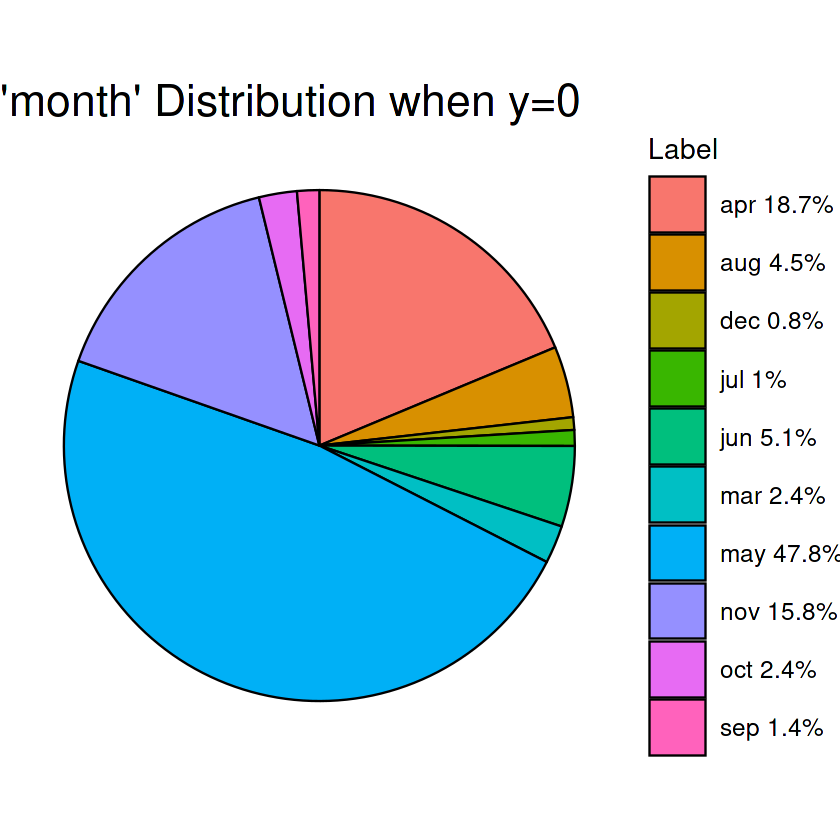

In [19]:
month_plotdata1 <- df %>%
    select(month, y) %>%
    filter(y==1) %>%
    count() %>%
    mutate(prop = round(freq/sum(freq), 3))

month_plotdata2 <- df %>%
    select(month, y) %>%
    filter(y==0) %>%
    count() %>%
    mutate(prop = round(freq/sum(freq), 3))

month_label1 <- paste0(month_plotdata1$month, " ", 
                         month_plotdata1$prop * 100, "%")

month_label2 <- paste0(month_plotdata2$month, " ", 
                         month_plotdata2$prop * 100, "%")


month_pie1 <- ggplot(month_plotdata1,
       aes(x="",y=prop,fill=month)) +
  geom_bar(width = 1, 
           stat = "identity",
           color = "black") +
  coord_polar("y", start = 0, direction = -1) +
  theme_void() +
  theme(legend.key.size = unit(35, "pt"),
        plot.title  = element_text(size = rel(2.4)),
        legend.text = element_text(size = rel(1.3)),
        legend.title = element_text(size = rel(1.5))
        ) +
  labs(title = "'month' Distribution when y=1") +
  scale_fill_discrete(labels = month_label1, name="Label")

month_pie2 <- ggplot(month_plotdata2,
       aes(x="",y=prop,fill=month)) +
  geom_bar(width = 1, 
           stat = "identity",
           color = "black") +
  coord_polar("y", start = 0, direction = -1) +
  theme_void() +
  theme(legend.key.size = unit(35, "pt"),
        plot.title  = element_text(size = rel(2.4)),
        legend.text = element_text(size = rel(1.3)),
        legend.title = element_text(size = rel(1.5))
        ) +
  labs(title = "'month' Distribution when y=0") +
  scale_fill_discrete(labels = month_label2, name="Label")

month_pie1

month_pie2

In [20]:
pdays_plotdata1 <- df %>%
    select(pdays, y) %>%
    filter(y==0) %>%
    count() %>%
    mutate(prop = round(freq/sum(freq), 3))

pdays_label1 <- paste0(pdays_plotdata1$pdays, " ", 
                        pdays_plotdata1$prop * 100, "%")

pdays_pie1 <- ggplot(pdays_plotdata1,
       aes(x="",y=prop,fill=pdays)) +
  geom_bar(width = 1, 
           stat = "identity",
           color = "black") +
  coord_polar("y", start = 0, direction = -1) +
  theme_void() +
  theme(legend.key.size = unit(35, "pt"),
        plot.title  = element_text(size = rel(2.4)),
        legend.text = element_text(size = rel(1.3)),
        legend.title = element_text(size = rel(1.5)),
        legend.position = "bottom"
        ) +
  labs(title = "'pdays' Distribution when y=0") +
  scale_fill_discrete(labels = pdays_label1, name="Label")

pdays_plotdata2 <- df %>%
    select(pdays, y) %>%
    filter(y==1) %>%
    count() %>%
    mutate(prop = round(freq/sum(freq), 3))

pdays_label2 <- paste0(pdays_plotdata2$pdays, " ", 
                        pdays_plotdata2$prop * 100, "%")

pdays_pie2 <- ggplot(pdays_plotdata2,
       aes(x="",y=prop,fill=pdays)) +
  geom_bar(width = 1, 
           stat = "identity",
           color = "black") +
  coord_polar("y", start = 0, direction = -1) +
  theme_void() +
  theme(legend.key.size = unit(35, "pt"),
        plot.title  = element_text(size = rel(2.4)),
        legend.text = element_text(size = rel(1.3)),
        legend.title = element_text(size = rel(1.5)),
        legend.position = "bottom"
        ) +
  labs(title = "'pdays' Distribution when y=1") +
  scale_fill_discrete(labels = pdays_label2, name="Label")

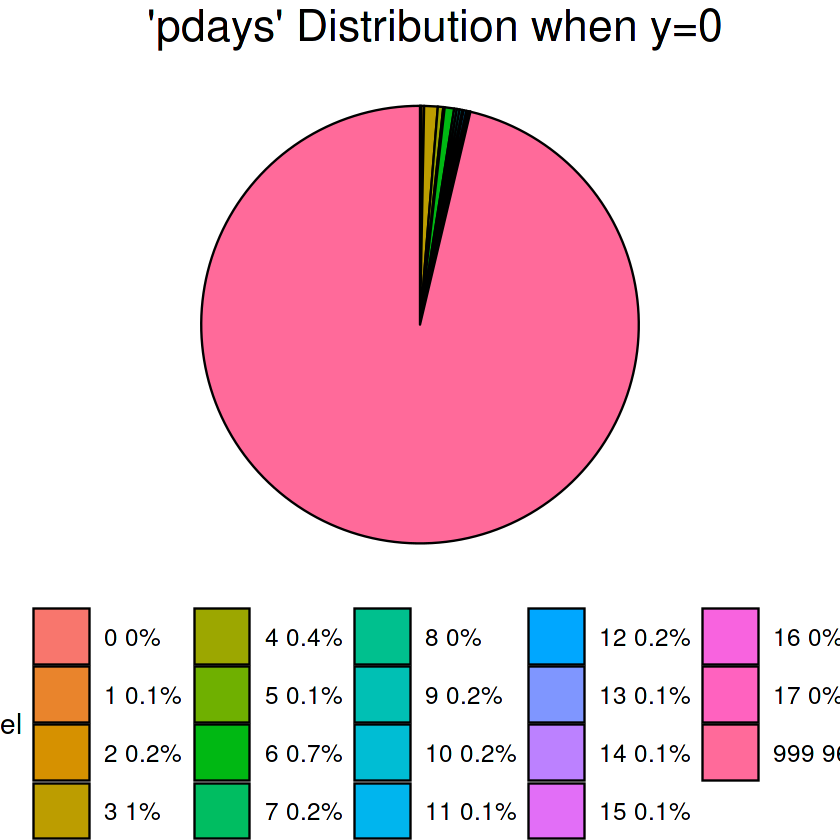

In [21]:
pdays_pie1

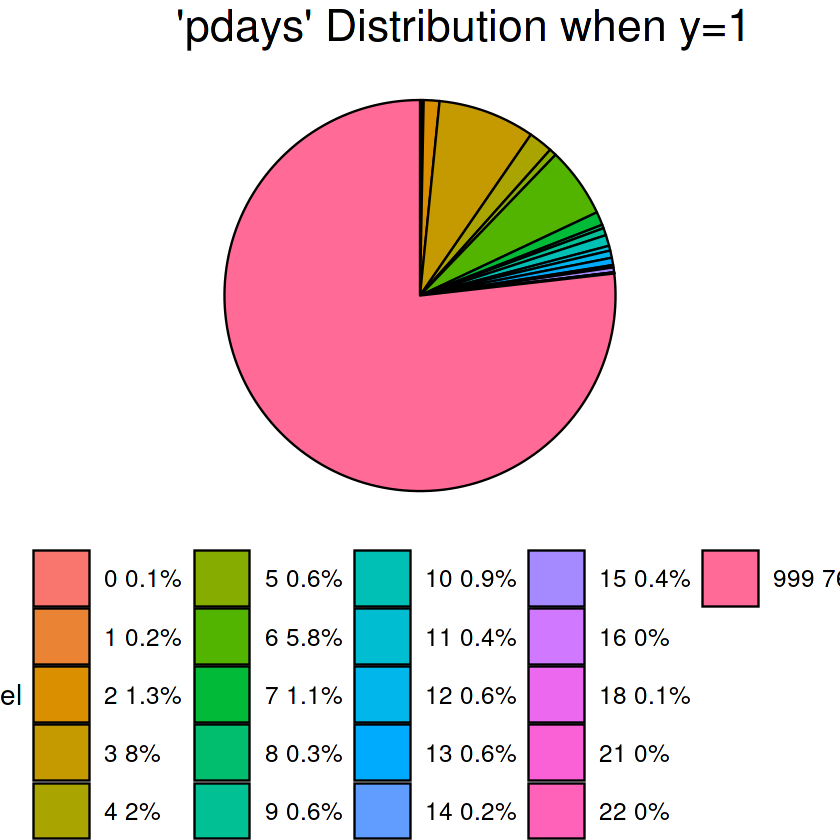

In [22]:
pdays_pie2

### Predition of Validation Set

In [23]:
# valid$y = as.integer(valid$y)

In [24]:
pred <- as.integer(predict(rf_model, valid)) 

acc = 1- (sum((abs((pred-1)-valid[,"y"]))) / length(pred))
acc

[1] 0.8464286

rf_model

In [25]:
n<-length(names(train_set))     #计算数据集中自变量个数，等同n=ncol(train_data)
err_rate=1     #设置模型误判率向量初始值

for(i in 1:(n-1)){
  set.seed(12345)
  rf_train <- randomForest(as.factor(train_set$y)~.,data=train_set,mtry=i,ntree=1000)
  err_rate[i] <- mean(rf_train$err.rate[,"OOB"])   #计算基于OOB数据的模型误判率均值  
}

err_rate     #展示所有模型误判率的均值
m <- which.min(err_rate) 
m

[1] 0.1788137 0.1652950 0.1621880 0.1631576 0.1618852 0.1637700 0.1646670
 [8] 0.1646121 0.1635930 0.1655226 0.1654087 0.1649004 0.1664383 0.1653806
[15] 0.1658600 0.1663410 0.1657497

[1] 5

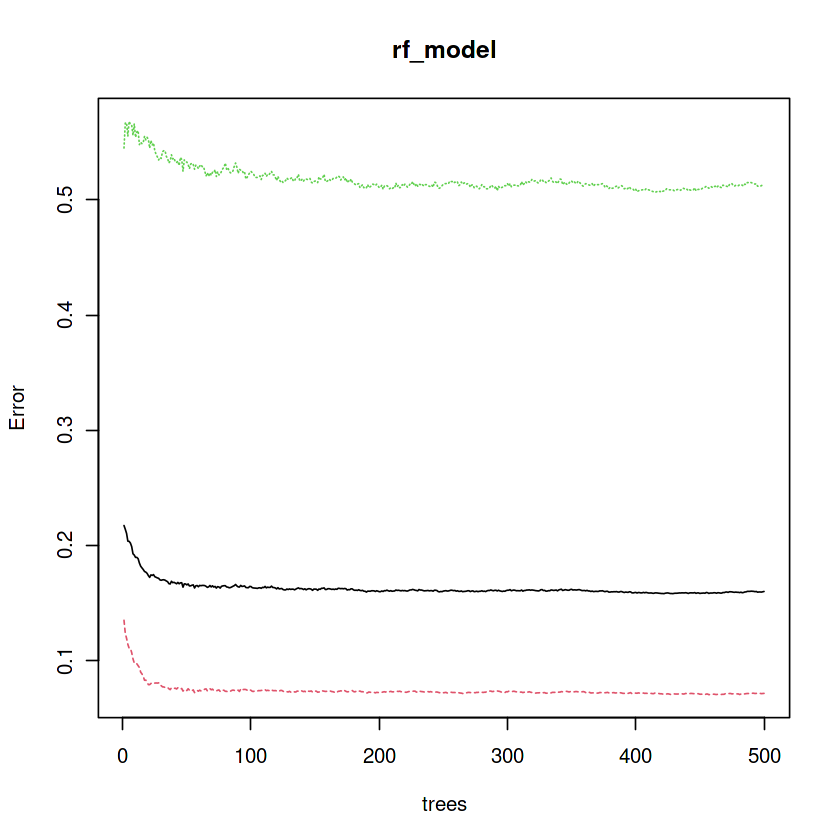

In [26]:
plot(rf_model)

In [27]:
rf_model = randomForest(as.factor(y)~.,data=train_set,importance=TRUE,proximity=TRUE, mtry = 4, oob_score =TRUE)
rf_model


Call:
 randomForest(formula = as.factor(y) ~ ., data = train_set, importance = TRUE,      proximity = TRUE, mtry = 4, oob_score = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 16.11%
Confusion matrix:
     0    1 class.error
0 8319  642  0.07164379
1 1162 1077  0.51898169

In [28]:
# pls.cmx <- confusionMatrix(data = pls_predicting, test$type)
# pls.cmx
# confusion <- rf_model$confusion[, c("0", "1")]
# autoplot(conf_mat(confusion), type = "heatmap")

In [29]:
pred <- as.integer(predict(rf_model, valid)) 

acc = 1- (sum((abs((pred-1)-valid[,"y"]))) / length(pred))
print(acc)
confusion = table(pred-1, valid$y)
confusion

[1] 0.8478571


   
       0    1
  0 2101  282
  1  144  273

In [30]:
acc = (confusion[1,1]+confusion[2,2]) / sum(confusion)
pred = confusion[1,1] / (confusion[1,1]+confusion[2,1])
recall = confusion[1,1] / (confusion[1,1]+confusion[1,2])
f_score = 2*(pred*recall)/(pred+recall)
f_score

[1] 0.9079516

[1] "conf_mat"


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



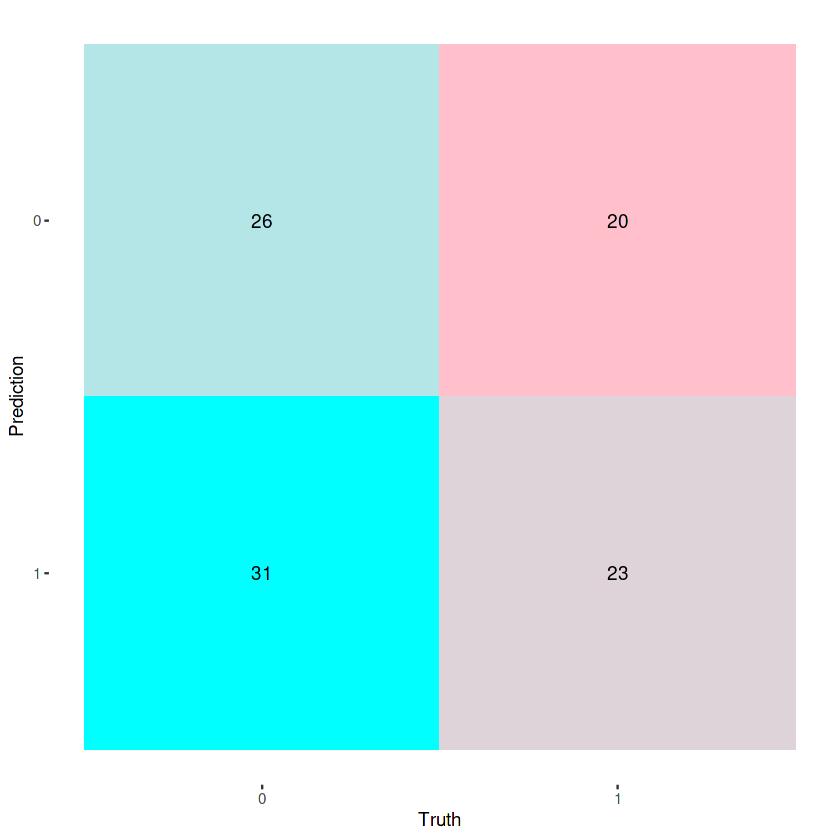

In [31]:
library(yardstick)
library(ggplot2)

set.seed(123)
truth_predicted <- data.frame(
  obs = sample(0:1,100, replace = T),
  pred = sample(0:1,100, replace = T)
)
truth_predicted$obs <- as.factor(truth_predicted$obs)
truth_predicted$pred <- as.factor(truth_predicted$pred)

cm <- conf_mat(truth_predicted, obs, pred)
print(class(cm))
autoplot(cm, type = "heatmap") +
  scale_fill_gradient(low = "pink", high = "cyan")